In [105]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import highlighting_functions as hf
from importlib import reload

_ = reload(hf)

In [106]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

print("# tokens", len(tokens))

known_default = {
    "assign": r"=",
    "punct": r",;",
    "op": r"!%&/+-*:",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": r"for|while|foreach|as|in|if|else|elif|and|or|not",
}


# first: tag individual tokens
tags = hf.tag_individuals(tokens, tags, known_default)

# second: context

tags = hf.tag_variables(tokens, tags)
tags = hf.tag_functions(tokens, tags)


In [107]:
tokens, tags = hf.tokenize(text)
print(tokens)

['print', '("#', ' ', 'tokens', '",', ' ', 'len', '(', 'tokens', '))', '\n\n', 'known_default', ' ', '=', ' ', '{', '\n    ', '"', 'assign', '":', ' ', 'r', '"=",', '\n    ', '"', 'punct', '":', ' ', 'r', '",;",', '\n    ', '"', 'op', '":', ' ', 'r', '"!%&/+-*:",', '\n    ', '"', 'brac_op', '":', ' ', 'r', '"([{",', '\n    ', '"', 'brac_cl', '":', ' ', 'r', '")]}",', '\n    ', '"', 'keyword', '":', ' ', 'r', '"', 'for', '|', 'while', '|', 'foreach', '|', 'as', '|', 'in', '|', 'if', '|', 'else', '|', 'elif', '|', 'and', '|', 'or', '|', 'not', '",', '\n', '}', '\n\n\n', '#', ' ', 'first', ':', ' ', 'tag', ' ', 'individual', ' ', 'tokens', '\n', 'tags', ' ', '=', ' ', 'hf', '.', 'tag_individuals', '(', 'tokens', ',', ' ', 'tags', ',', ' ', 'known_default', ')', '\n\n', '#', ' ', 'second', ':', ' ', 'context', '\n\n', 'tags', ' ', '=', ' ', 'hf', '.', 'tag_variables', '(', 'tokens', ',', ' ', 'tags', ')', '\n', 'tags', ' ', '=', ' ', 'hf', '.', 'tag_functions', '(', 'tokens', ',', ' ', 'ta

## tagging

In [108]:
print("# tokens", len(tokens))

known_default = {
    "assign": r"=",
    "punct": r",;",
    "op": r"!%&/+-*:",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": r"for|while|foreach|as|in|if|else|elif|and|or|not",
}


# first: tag individual tokens
tags = hf.tag_individuals(tokens, tags, known_default)

# second: context

tags = hf.tag_variables(tokens, tags)
tags = hf.tag_functions(tokens, tags)

# tokens 152


In [109]:
for x in zip(tags, tokens):
    if x[0] == "unk":
        print("\t".join(x))

unk	tokens
unk	#
unk	first
unk	tag
unk	individual
unk	tokens
unk	hf
unk	.
unk	tokens
unk	#
unk	second
unk	context
unk	hf
unk	.
unk	tokens
unk	hf
unk	.
unk	tokens


## features

In [110]:
feature_names = (
    "x",
    "x",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

### bracket level

In [111]:
brac_level = []
current_level = 0
for i, token in enumerate(tokens):
    tag = tags[i]
    if tag == "brac_op":
        brac_level.append(current_level)
        current_level += 1
        tags[i] = f"brac{current_level}"
    elif tag == "brac_cl":
        tags[i] = f"brac{current_level}"
        current_level -= 1
        brac_level.append(current_level)
    else:
        brac_level.append(current_level)

## comments, unknowns per line?

- many unknowns
- Starts with token not present in completely tagged lines
- comment symbol
    - not after assign
    - not inside brackets
    - NOT necessatily start of line

In [129]:
lines = []
lines_tags = []

current_line = []
current_line_tags = []
for i, token in enumerate(tokens):
    if "\n" in token:
        lines.append(current_line)
        lines_tags.append(current_line_tags)
        current_line = []
        current_line_tags = []
    else:
        current_line.append(token)
        current_line_tags.append(tags[i])

unks_per_line = [np.array(list([t == "var"] for t in L)).sum() for L in lines]
unks_per_line


[0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0]

feature matrix (152, 8)
(0, 'x') (1, 'x') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


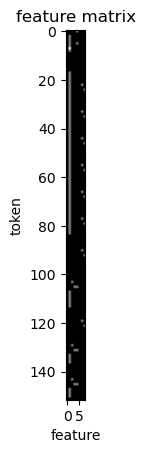

In [ ]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 1] = np.array(brac_level)

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features, cmap="gray")
plt.title("feature matrix")
plt.xlabel("feature")
plt.ylabel("token")
plt.show()

## classify

(152, 2)


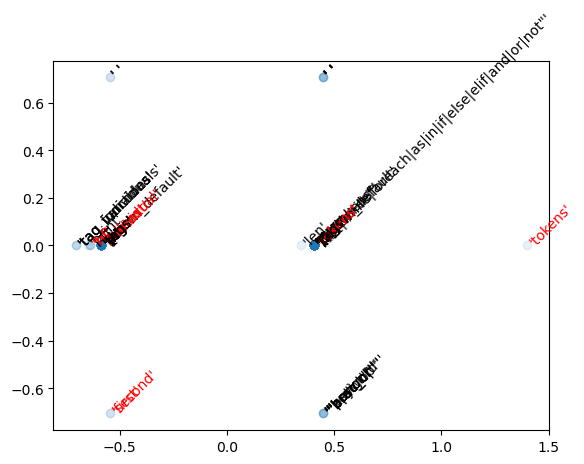

In [ ]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()

pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1], alpha=0.1)
for i, t in enumerate(tokens):
    c = "#000"
    if tags[i] == "unk":
        c = "r"
    elif tags[i] == "num":
        c = "g"

    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1], s=repr(t), rotation=45, color=c)

In [ ]:
classes = tuple(sorted(set(tags)))
print(classes)

('assign', 'brac1', 'brac2', 'func', 'keyword', 'op', 'punct', 'str', 'unk', 'var', 'wsp')


## cleanup

In [ ]:
print("# tokens/tags", len(tokens))

# Merge adjacent of same class
tokens, tags = hf.merge_adjacent(tokens, tags)

print("after merge # tokens/tags", len(tokens))
print("count unknown", sum([t == "unk" for t in tags]))

# tokens/tags 152
after merge # tokens/tags 120
count unknown 15


In [ ]:
print(tokens)

['print', '(', '"# tokens"', ',', ' ', 'len', '(', 'tokens', ')', ')', '\n\n', 'known_default', ' ', '=', ' ', '{', '\n    ', '"assign"', ':', ' ', 'r', '"="', ',', '\n    ', '"punct"', ':', ' ', 'r', '",;"', ',', '\n    ', '"op"', ':', ' ', 'r', '"!%&/+-*:"', ',', '\n    ', '"brac_op"', ':', ' ', 'r', '"([{"', ',', '\n    ', '"brac_cl"', ':', ' ', 'r', '")]}"', ',', '\n    ', '"keyword"', ':', ' ', 'r', '"for|while|foreach|as|in|if|else|elif|and|or|not"', ',', '\n', '}', '\n\n\n', '#', ' ', 'first', ':', ' ', 'tag', ' ', 'individual', ' ', 'tokens', '\n', 'tags', ' ', '=', ' ', 'hf.', 'tag_individuals', '(', 'tokens', ',', ' ', 'tags', ',', ' ', 'known_default', ')', '\n\n', '#', ' ', 'second', ':', ' ', 'context', '\n\n', 'tags', ' ', '=', ' ', 'hf.', 'tag_variables', '(', 'tokens', ',', ' ', 'tags', ')', '\n', 'tags', ' ', '=', ' ', 'hf.', 'tag_functions', '(', 'tokens', ',', ' ', 'tags', ')']


In [ ]:
EXCLUDE_TAGS = ("unk", "wsp")
html_text = hf.tokens_to_html(tokens, tags, EXCLUDE_TAGS)

print(html_text)

<div class="code-snippet"><span class="func">print</span><span class="brac1">(</span><span class="str">&quot;# tokens&quot;</span><span class="punct">,</span> <span class="func">len</span><span class="brac2">(</span>tokens<span class="brac2">)</span><span class="brac1">)</span><br>
<br>
<span class="var">known_default</span> <span class="assign">=</span> <span class="brac1">{</span><br>
&nbsp; &nbsp; <span class="str">&quot;assign&quot;</span><span class="op">:</span> <span class="keyword">r</span><span class="str">&quot;=&quot;</span><span class="punct">,</span><br>
&nbsp; &nbsp; <span class="str">&quot;punct&quot;</span><span class="op">:</span> <span class="keyword">r</span><span class="str">&quot;,;&quot;</span><span class="punct">,</span><br>
&nbsp; &nbsp; <span class="str">&quot;op&quot;</span><span class="op">:</span> <span class="keyword">r</span><span class="str">&quot;!%&amp;/+-*:&quot;</span><span class="punct">,</span><br>
&nbsp; &nbsp; <span class="str">&quot;brac_op&quot;

## output

In [ ]:
css_link = '<link rel="stylesheet" type="text/css" href="_rando_style.css">'
final_html = f"""
<head>
    {css_link}
</head>
<body>
    {html_text}
</body>
"""

with open("output.html", "w") as f:
    f.write(final_html)